In [50]:
import pandas as pd

import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge
import spotipy

from matplotlib import pyplot as plt

In [106]:
data = pd.read_csv('data.csv')
data_no_duplicates = pd.read_csv('data_no_duplicates.csv')

In [107]:
# scaling data
def pre_process_data(data):
    data.drop_duplicates(subset=['track_id'], keep=False, inplace=True)
    metadata = ['artist', 'album', 'track_name', 'track_id', 'country', 'continent', 'popularity'] # features that are actually not required 
    feature_data = np.asarray(data.drop(metadata, axis = 1))
    scaled_data = StandardScaler().fit_transform(feature_data)
    return scaled_data

In [108]:
scaled_data = pre_process_data(data)
scaled_data_no_duplicates = pre_process_data(data_no_duplicates)

In [54]:
pca = PCA(n_components=8)
projected_data = pca.fit_transform(scaled_data)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.19994236 0.1239975  0.10127112 0.09314045 0.08529057 0.08330976
 0.07582055 0.06692234]
0.8296946425468897


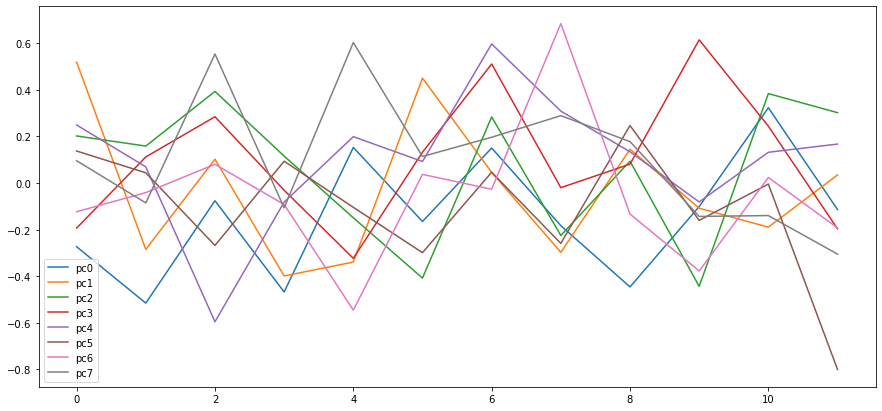

In [55]:
pca.components_[0]
x = np.arange(12)
fig = plt.figure(figsize=(15,7))
for i,pc in enumerate(pca.components_):
    plt.plot(x, pc, label=f'pc{i}')
plt.legend()

### Regression

In [56]:
def get_root_mean_squared_error(predictions, labels):
    rsme = 0
    for pred, label in zip(predictions, labels):
        rsme += (label - pred)**2
    return np.sqrt(1/len(predictions) * rsme)

In [57]:
X = scaled_data
y = data['popularity'].values

In [58]:
########################################## normal regression #######################################################

def print_model_performance(reg, X_train, X_test, y_train, y_test):
    predictions = reg.predict(X_train)
    print(f'prediction: {list(predictions[:5])}')
    print(f'y: {y_train[:5]}')
    rsme_normal = np.sqrt(mean_squared_error(y_train, predictions))
    print(f'train error: {rsme_normal}')

    # cross validation
    model = LinearRegression()
    scorer = make_scorer(get_root_mean_squared_error)
    cv = KFold(n_splits=5, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scorer)
    print(f'mean cross validation error: {scores.mean()}')

    # get test error
    predictions_training = reg.predict(X_test)
    print(f'test error: {np.sqrt(mean_squared_error(y_test, predictions_training))}')

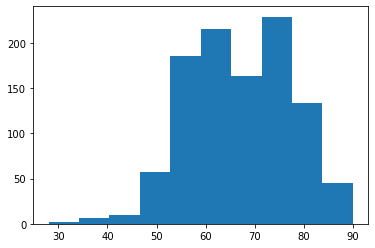

In [59]:
# look at popularity distribution
plt.hist(data['popularity']);

In [60]:
# split data into test and trainings set
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, test_size = 0.33, random_state = 42)

In [102]:
# plot residuals
def plot_residuals(X_train, y_train, reg):
    prediction = reg.predict(X_train)
    res = y_train - prediction
    fig = plt.figure(figsize=(13,7))
    plt.subplot(221)
    plt.title('residuals against prediction')
    plt.plot(prediction, res, 'b.');
    plt.subplot(222)
    plt.hist(res, bins=50)
    plt.title('residual frequency')
    plt.subplot(223)
    plt.title('predictions')
    plt.hist(prediction, bins=50)
    plt.subplot(224)
    plt.title('y')
    plt.hist(y_train, bins=50)


**normal data set**

In [103]:
# perform linear regerssion and evaluate
reg = LinearRegression().fit(X_train, y_train)
print_model_performance(reg, X_train, X_test, y_train, y_test)

prediction: [69.37452596189219, 68.47508857143644, 68.17461479302474, 65.44855121839184, 72.49635224935558]
y: [54. 76. 74. 47. 73.]
train error: 9.903608373114572
mean cross validation error: 10.139761435459464
test error: 10.366843965523662


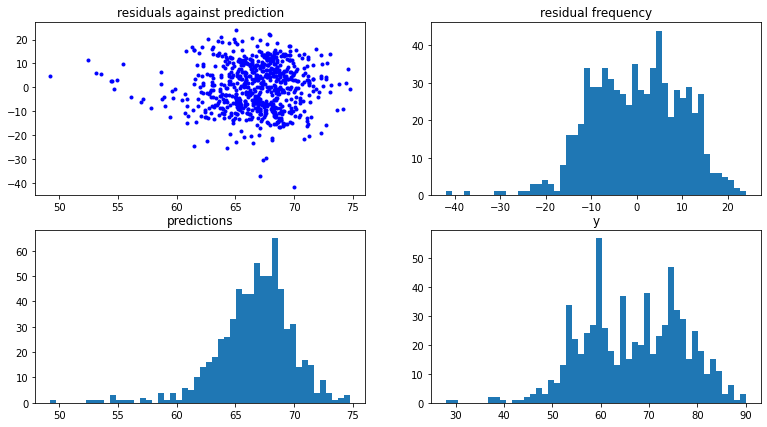

In [104]:
plot_residuals(X_train, y_train, reg)

In [105]:
len(X_train)

701

**data with no duplictes**

In [14]:
# split data into test and trainings set
X_train, X_test, y_train, y_test = train_test_split(scaled_data_no_duplicates, y, test_size = 0.33, random_state = 42)

In [15]:
# perform linear regerssion and evaluate
reg = LinearRegression().fit(X_train, y_train)
print_model_performance(reg, X_train, X_test, y_train, y_test)

prediction: [69.37452596189219, 68.47508857143644, 68.17461479302474, 65.44855121839184, 72.49635224935558]
y: [54. 76. 74. 47. 73.]
train error: 9.903608373114572
mean cross validation error: 10.141405636342867
test error: 10.366843965523662


With linear regression, even the trainings error is high.

### Evaluate predictions with residual plot

does not look proissing, lots of outliers

#### Support vector regression

In [16]:
from sklearn.svm import SVR

regressor = SVR(kernel='rbf')
regressor.fit(X_train, y_train)
print_model_performance(regressor, X_train, X_test, y_train, y_test)

prediction: [67.67756127741637, 68.33269819487994, 67.32296312173307, 68.00066936463783, 72.89966373041314]
y: [54. 76. 74. 47. 73.]
train error: 9.751146239478512
mean cross validation error: 10.101660112598687
test error: 10.195296913784427


In [17]:
regressor = SVR()
scorer = make_scorer(get_root_mean_squared_error)

In [18]:
p_grid = {'kernel': ['linear', 'rbf', 'ploy']}
outer_cv = KFold(n_splits=5, shuffle=True)

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator=regressor, param_grid=p_grid, cv=outer_cv, scoring=scorer, verbose=5)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..................................kernel=linear; total time=   0.0s
[CV 2/5] END ..................................kernel=linear; total time=   0.0s
[CV 3/5] END ..................................kernel=linear; total time=   0.0s
[CV 4/5] END ..................................kernel=linear; total time=   0.0s
[CV 5/5] END ..................................kernel=linear; total time=   0.0s
[CV 1/5] END .....................................kernel=rbf; total time=   0.0s
[CV 2/5] END .....................................kernel=rbf; total time=   0.0s
[CV 3/5] END .....................................kernel=rbf; total time=   0.0s
[CV 4/5] END .....................................kernel=rbf; total time=   0.0s
[CV 5/5] END .....................................kernel=rbf; total time=   0.0s
[CV 1/5] END ....................................kernel=ploy; total time=   0.0s
[CV 2/5] END ....................................

/home/florian/miniconda3/envs/statistics/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florian/miniconda3/envs/statistics/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/florian/miniconda3/envs/statistics/lib/python3.8/site-packages/sklearn/svm/_base.py", line 226, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/home/florian/miniconda3/envs/statistics/lib/python3.8/site-packages/sklearn/svm/_base.py", line 277, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn/svm/_libsvm.pyx", line 176, in sklearn.svm._libsvm.fit
ValueError: 'ploy' is not in list

  warnings.warn("Estimator fit failed. The score on this train-

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVR(), param_grid={'kernel': ['linear', 'rbf', 'ploy']},
             scoring=make_scorer(get_root_mean_squared_error), verbose=5)

In [19]:
clf.best_score_

10.29004719182846

### load keggel data 

keggel data set is used to get more training data

In [20]:
keggel_spotify = pd.read_csv('archive/tracks_features.csv', header=0)

In [21]:
keggel_spotify[keggel_spotify['year'] > 2005]

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
22,2SwgVZn9S4NGueAaEAryf1,Man on a Mission,Do It for Love,4evw6IBex3N8x1oA2axMTH,['Daryl Hall & John Oates'],['77tT1kLj6mCWtFNqiOmP9H'],1,1,False,0.787,...,0.0315,0.29200,0.000025,0.1010,0.962,119.946,224307,4.0,2018,2018-04-10
23,0QCQ1Isa0YPVyIbs6JwpO1,Do It for Love,Do It for Love,4evw6IBex3N8x1oA2axMTH,['Daryl Hall & John Oates'],['77tT1kLj6mCWtFNqiOmP9H'],2,1,False,0.587,...,0.0586,0.10700,0.000000,0.0574,0.832,87.976,238000,4.0,2018,2018-04-10
24,3kIBEFhsZOeeKGebxRraOb,Someday We'll Know,Do It for Love,4evw6IBex3N8x1oA2axMTH,['Daryl Hall & John Oates'],['77tT1kLj6mCWtFNqiOmP9H'],3,1,False,0.565,...,0.0308,0.02330,0.000010,0.0819,0.461,109.977,268013,4.0,2018,2018-04-10
25,5dNDRw6qjDcnbW3luRhElU,Forever for You,Do It for Love,4evw6IBex3N8x1oA2axMTH,['Daryl Hall & John Oates'],['77tT1kLj6mCWtFNqiOmP9H'],4,1,False,0.651,...,0.0240,0.56200,0.000006,0.1860,0.370,97.030,277813,4.0,2018,2018-04-10
26,561UU4MvlsCenN1x7leYCh,Life's Too Short,Do It for Love,4evw6IBex3N8x1oA2axMTH,['Daryl Hall & John Oates'],['77tT1kLj6mCWtFNqiOmP9H'],5,1,False,0.833,...,0.0347,0.07600,0.013600,0.0731,0.974,116.013,209960,4.0,2018,2018-04-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204020,0EsMifwUmMfJZxzoMPXJKZ,Gospel of Juke,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],2,1,False,0.264,...,0.0672,0.00935,0.002240,0.3370,0.415,159.586,276213,4.0,2014,2014-01-09
1204021,2WSc2TB1CSJgGE0PEzVeiu,Prism Visions,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],3,1,False,0.796,...,0.0883,0.10400,0.644000,0.0749,0.781,121.980,363179,4.0,2014,2014-01-09
1204022,6iProIgUe3ETpO6UT0v5Hg,Tokyo 360,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],4,1,False,0.785,...,0.0564,0.03040,0.918000,0.0664,0.467,121.996,385335,4.0,2014,2014-01-09
1204023,37B4SXC8uoBsUyKCWnhPfX,Yummy!,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],5,1,False,0.665,...,0.0409,0.00007,0.776000,0.1170,0.227,124.986,324455,4.0,2014,2014-01-09


In [22]:
cid = '020f2ed496864af6ab98a08846eac5da'
secret = 'abd17ef2d04d4d3abd706ec03db71646'

client_credentials_manager = spotipy.SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [23]:
from tqdm import tqdm
import random

In [24]:
def get_popularity(keggel_spotify):
    popularity = []
    for idx in tqdm(keggel_spotify.id):
        popularity.append((sp.track(idx)['popularity']))
    keggel_spotify['popularity'] = popularity
    return keggel_spotify

In [25]:
random.seed(69)
idx = np.arange(0,len(keggel_spotify))
sample_idx = random.sample(list(idx), 1000)

In [27]:
sample_keggel = keggel_spotify.iloc[sample_idx]
sample_keggel = get_popularity(sample_keggel)

100%|███████████████████████████████████████| 1000/1000 [01:31<00:00, 10.97it/s]
/tmp/ipykernel_19928/1063456381.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keggel_spotify['popularity'] = popularity


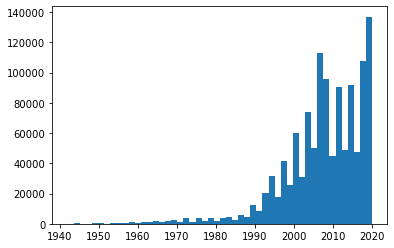

In [28]:
plt.hist(keggel_spotify['year'][keggel_spotify['year']>1940], bins=50);

(array([748., 106.,  59.,  41.,  26.,  10.,   6.,   1.,   2.,   1.]),
 array([ 0. ,  8.3, 16.6, 24.9, 33.2, 41.5, 49.8, 58.1, 66.4, 74.7, 83. ]),
 <BarContainer object of 10 artists>)

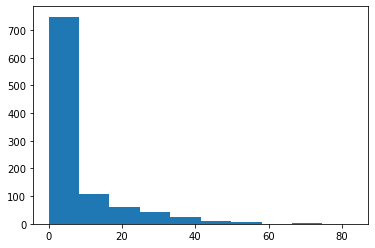

In [29]:
plt.hist(sample_keggel['popularity'])

In [30]:
sample_keggel.head()
sample_keggel.to_csv('keggel_sample.csv', index=None)

## Build training data with charts and keggel songs

Older songs seem to have no popularity measure, so exclude them

In [109]:
data_no_duplicates.drop_duplicates(subset=['track_id'], keep=False, inplace=True)
metadata = ['artist', 'album', 'track_name', 'track_id', 'country', 'continent'] # features that are actually not required 
data_no_duplicates = data_no_duplicates.drop(metadata, axis = 1)

In [110]:
# get shared features
sample_keggel_cols = set(sample_keggel.columns)
data_no_duplicates_cols = set(data_no_duplicates.columns)
intersection =  list(data_no_duplicates_cols.intersection(sample_keggel_cols))
print(intersection)

['mode', 'valence', 'duration_ms', 'key', 'instrumentalness', 'speechiness', 'loudness', 'energy', 'liveness', 'tempo', 'time_signature', 'popularity', 'danceability']


In [111]:
# separate features and labels
training_keggel = sample_keggel[intersection]
training_data = data_no_duplicates[intersection]
regression_data = training_data.append(training_keggel)
y = regression_data['popularity'].reset_index(drop=True)
regression_data = regression_data.drop('popularity', axis=1).reset_index(drop=True)

In [112]:
# exclude categotial varibles from scaling
cat_features = ['key', 'mode', 'time_signature']
categorial_columns = regression_data[cat_features].astype(str).reset_index(drop=True)
regression_data = regression_data.drop(cat_features, axis=1)

In [113]:
# scale data
scaled_regression_data = StandardScaler().fit_transform(regression_data)
scaled_regression_data = pd.DataFrame(scaled_regression_data)
scaled_regression_data.columns = regression_data.columns
# merge with categorial data
scaled_regression_data[cat_features] = categorial_columns

In [114]:
print(scaled_regression_data)

       valence  duration_ms  instrumentalness  speechiness  loudness  \
0     1.628326    -0.281588         -0.478854     1.362266 -0.267807   
1     1.183090    -0.321624         -0.479879    -0.423193  0.819295   
2     0.016806    -0.131770         -0.479913    -0.111983  0.161188   
3     1.328875    -0.196451         -0.479913     1.691260  0.145812   
4     0.060148    -0.525705         -0.004216     1.113298 -0.226073   
...        ...          ...               ...          ...       ...   
2042 -1.751926     1.344121         -0.444151    -0.519224 -2.581573   
2043  1.837154    -0.188885         -0.479871    -0.534340  0.921517   
2044 -0.629378    -0.363477         -0.479913    -0.600139 -0.362595   
2045  1.100347     0.911899         -0.479909    -0.550345  0.478498   
2046 -1.393767    -0.298180          2.583439    -0.303155 -3.361840   

        energy  liveness     tempo  danceability key mode time_signature  
0     0.047553  1.029446  0.277935      1.761465  11    0   

In [115]:
# split data into test and trainings set
X_train, X_test, y_train, y_test = train_test_split(scaled_regression_data, y, test_size = 0.33, random_state = 42)

prediction: [11.016684214457996, 15.152115021241425, 13.631283898377916, 43.410639436986386, 27.93899291125006]
y: 1639     5.0
1310     1.0
1320    15.0
1023    61.0
1235     0.0
Name: popularity, dtype: float64
train error: 24.619353180144376
mean cross validation error: 24.864047080247072
test error: 27.22463401342618


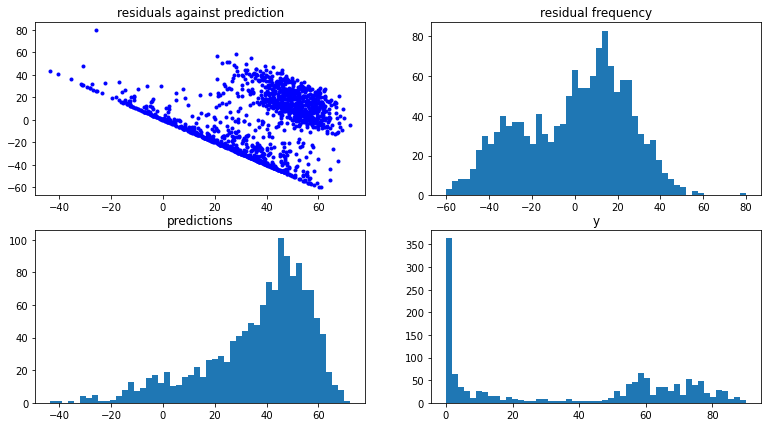

In [116]:
# perform linear regerssion and evaluate
reg = LinearRegression().fit(X_train, y_train)
print_model_performance(reg, X_train, X_test, y_train, y_test)
plot_residuals(X_train, y_train, reg)

prediction: [21.849525801537464, 25.878840285907753, 14.213263541515497, 39.474524293295765, 35.13769724573527]
y: 1639     5.0
1310     1.0
1320    15.0
1023    61.0
1235     0.0
Name: popularity, dtype: float64
train error: 25.60188037648019
mean cross validation error: 24.892756129096586
test error: 27.45728318368986


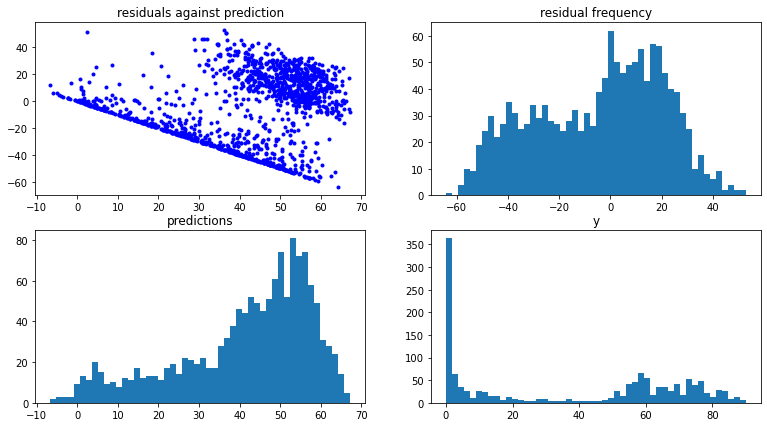

In [119]:
regressor = SVR(kernel='rbf')
regressor.fit(X_train, y_train)
print_model_performance(regressor, X_train, X_test, y_train, y_test)
plot_residuals(X_train, y_train, regressor)

In [134]:
training_keggel.shape
train_keggel = scaled_regression_data.iloc[-1000:]
label_keggel = y.iloc[-1000:]

In [137]:
# split data into test and trainings set
X_train, X_test, y_train, y_test = train_test_split(train_keggel, label_keggel, test_size = 0.2, random_state = 42)

prediction: [3.883881072552903, 7.040868742550165, 9.896358828767934, 3.4426179585724217, 3.537336835004073]
y: 1076     1.0
1582     1.0
1742     0.0
1604    24.0
1883     0.0
Name: popularity, dtype: float64
train error: 10.607598276886987
mean cross validation error: 10.708737798967608
test error: 12.84231089616976


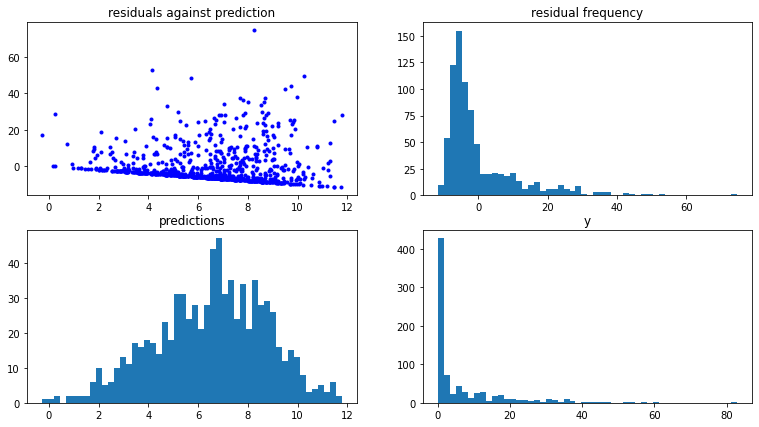

In [138]:
# perform linear regerssion and evaluate
reg = LinearRegression().fit(X_train, y_train)
print_model_performance(reg, X_train, X_test, y_train, y_test)
plot_residuals(X_train, y_train, reg)